# Koen & Kondlo (2009) Mass Function

One of the available mass functions in imf is an implementation of the "error-convolved power law" defined in Equations (3) and (5) of the [Koen & Kondlo 2009](https://ui.adsabs.harvard.edu/abs/2009MNRAS.397..495K/abstract) paper, "Fitting power-law distributions to data with measurement errors".

$$f_y(y) = \frac{1}{\sqrt{2\pi}\sigma} \frac{\gamma}{L^{-\gamma}-U^{-\gamma}} \int_L^U x^{-(\gamma+1)} \exp\left[-\frac{1}{2}\left(\frac{y-x}{\sigma}\right)^2\right]$$

$$F_y(y) = \Phi\left(\frac{y-U}{\sigma}\right)+\frac{1}{\sqrt{2\pi}\sigma}\frac{1}{L^{-\gamma}-U^{-\gamma}}\times\int_L^U \left(L^{-\gamma}-x^{-\gamma}\right) \exp\left[-\frac{1}{2}\left(\frac{y-x}{\sigma}\right)^2\right]$$

$$\Phi(v) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{v}e^{-t^2/2}dt$$

This function has to be integrated numerically.  It can therefore be prone to significant numerical error. (See [issue #12](https://github.com/keflavich/imf/issues/12) on the imf repository for an example.)

As of [PR #38](a13e2a64e32528a2dc08294906cb73f8b9fc6392), ``KoenConvolvedPowerLaw`` is more accurate. 


Instead of performing the KK09 integrals when called, ``KoenConvolvedPowerLaw`` constructs a lookup table of values at log-spaced points when instantiated and interpolates between these points.  

However, there are significant enough drawbacks to this method that we have elected to preserve the original infrastructure in a new MassFunction class, ``SpotKoenConvolvedPowerLaw`` (so named because it does all the integration "on the spot"). In this notebook, we demonstrate the differences between the two.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imf import KoenConvolvedPowerLaw, SpotKoenConvolvedPowerLaw
from time import perf_counter

In [2]:
L = 0.03
U = 120
gamma = 0.9
sigma = 0.4

In [3]:
ntrials = 10


When instantiated, KoenConvolvedPowerLaws are evaluated at a number of evenly log-spaced points (default 200, but can be more or less depending on user preference). 

SpotKoenConvolvedPowerLaw does not perform any integrations on instantiation and is therefore faster to create.

In [4]:
t0 = perf_counter()
for n in range(ntrials):
    spot_koc = SpotKoenConvolvedPowerLaw(L,U,gamma,sigma)
avg_spot_time = (perf_counter() - t0)/ntrials
print(f'Average time to create on-the-spot powerlaw: {avg_spot_time} s')

Average time to create on-the-spot powerlaw: 0.011616653390228748 s


In [5]:
t0 = perf_counter()
for n in range(ntrials):
    int_koc = KoenConvolvedPowerLaw(L,U,gamma,sigma)
avg_int_time = (perf_counter() - t0)/ntrials
print(f'Average time to create interpolated powerlaw: {avg_int_time} s')

Average time to create interpolated powerlaw: 10.344878901075571 s


In [6]:
print(f'Interp/spot creation ratio: {avg_int_time/avg_spot_time}')

Interp/spot creation ratio: 890.521439658093


``SpotKoenConvolvedPowerLaw`` is slower to evaluate than ``KoenConvolvedPowerLaw``. The difference between the two is large, but in absolute time, evaluating both functions at a single point is still fairly fast.

In [7]:
integral_form = False

In [8]:
t0 = perf_counter()
for n in range(ntrials):
    spot_func = spot_koc(10,integral_form=integral_form)
avg_spot_time = (perf_counter() - t0)/ntrials
print(f'Average time to evaluate scalar on the spot: {avg_spot_time} s')

Average time to evaluate scalar on the spot: 0.03687896430492401 s


In [9]:
t0 = perf_counter()
for n in range(ntrials):
    int_func = int_koc(10,integral_form=integral_form)
avg_int_time = (perf_counter() - t0)/ntrials
print(f'Average time to interpolate scalar: {avg_int_time} s')

Average time to interpolate scalar: 1.8801074475049973e-05 s


In [10]:
print(f'Interp/spot scalar evaluation ratio: {avg_int_time/avg_spot_time}')

Interp/spot scalar evaluation ratio: 0.0005098048394092154


However, if you need to evaluate the function at multiple points, the time difference can accumulate.

In [11]:
m = np.geomspace(L,U,100)

In [12]:
t0 = perf_counter()
for n in range(ntrials):
    spot_func = spot_koc(m,integral_form=integral_form)
avg_spot_time = (perf_counter() - t0)/ntrials
print(f'Average time to evaluate array on the spot: {avg_spot_time} s')

Average time to evaluate array on the spot: 1.0681172168813646 s


In [13]:
t0 = perf_counter()
for n in range(ntrials):
    int_func = int_koc(m,integral_form=integral_form)
avg_int_time = (perf_counter() - t0)/ntrials
print(f'Average time to interpolate array: {avg_int_time} s')

Average time to interpolate array: 1.608799211680889e-05 s


In [14]:
print(f'Interp/spot array evaluation ratio: {avg_int_time/avg_spot_time}')

Interp/spot array evaluation ratio: 1.5062009920392264e-05


## Accuracy

``KoenConvolvedPowerLaw`` relies on interpolation, which produces small inaccuracies. 

 The default number of points in the lookup table is sufficient to capture the behavior of the mass function, but the values diverge from on-the-spot integration (though they can be expected to remain within .01% of the "true" values).

Text(0, 0.5, 'PDF')

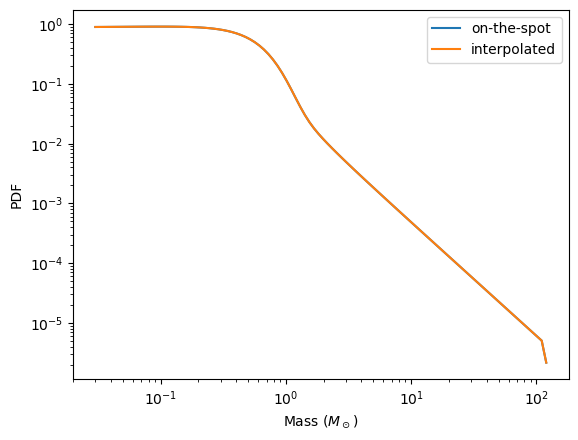

In [15]:
plt.plot(m,spot_func,label='on-the-spot')
plt.plot(m,int_func,label='interpolated')
plt.xscale('log'); plt.yscale('log')
plt.legend()
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('PDF')

Text(0, 0.5, 'Interpolated/On-the-spot')

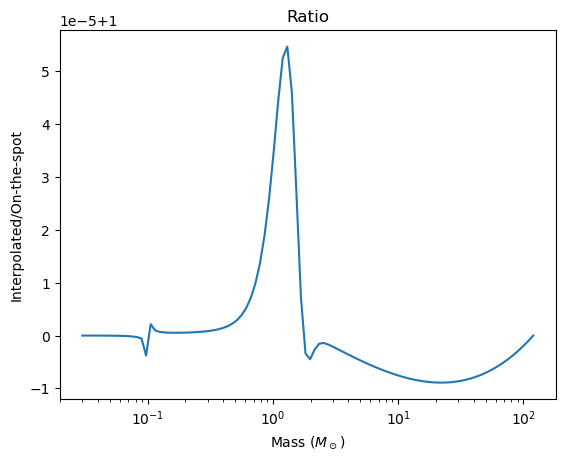

In [16]:
plt.plot(m,int_func/spot_func)
plt.xscale('log')
plt.title('Ratio')
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('Interpolated/On-the-spot')

In summation, both implementations have strengths and weaknesses, and may be preferred for different scenarios. Here are the pros and cons for both:

**Interpolation:**:

|               | PRO         | CON |
| ------------- | -----------           | ----------- |
| Interpolation |       |     |
|               | Quick evaluation      | Slow instantiation       |
|               | Enables random sampling          | Diverges from on-the-spot        |
|               |         | Can cause incorrect optimal sampling (rarely)     |
| On-the-spot   |   |   |
|   | Quick instantiation | Slow evaluation |
|               | Good accuracy        | Cannot be randomly sampled |
